## Actitracker labeled dataset NN model
This model will use keras to predict activity from sessionized accelerometer data, via the actitracker dataset (http://www.cis.fordham.edu/wisdm/dataset.php). 

### Data Processing

In [184]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import matplotlib.pylab as plt
from math import log
import seaborn as sns
%matplotlib inline

#### Data load

In [185]:
DATA_FOLDER = 'Data/WISDM_ar_v1.1/'
DATA_FILE = 'raw_data_fixed.txt'
actitracker = pd.read_csv(
    DATA_FOLDER+DATA_FILE ,
    sep=',' ,
    lineterminator=';' ,
    header=None ,
)
actitracker.columns = [
    'user' ,
    'activity' ,
    'timestamp' ,
    'x-accel' ,
    'y-accel' ,
    'z-accel' ,
    'NA' ,
]
del actitracker['NA']
accel_cols = ['x-accel','y-accel','z-accel']

#### Sessionize 

In [186]:
# re-calculate time in seconds
actitracker['time_seconds'] = actitracker['timestamp']*10e-9

# sort by user and time 
session_length = 100
actitracker = actitracker.sort_values(by=['user','time_seconds'])

# create sessions
actitracker['seq'] = xrange(actitracker.shape[0])
actitracker['session'] = actitracker.\
                           groupby(['user','activity'])['seq'].\
                           apply(lambda x: x%session_length == 0).\
                           fillna(0).cumsum()

#### Gather labels

In [187]:
# get session_labels 
ohe = OneHotEncoder(sparse=False); le = LabelEncoder()
labels = actitracker.groupby(['user','session'])['activity'].apply(lambda x: max(x))
le_labels = le.fit_transform(labels)
ohe_labels = ohe.fit_transform(le_labels.reshape(-1,1))
label_lookup = { k: v for k,v in set((i, v) for i,v in np.vstack((le_labels,labels)).T) }
Y = pd.DataFrame(ohe_labels,index=labels.index)

In [188]:
label_lookup

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

#### Calculate features 

In [189]:
# group by user and session
accel_cols = ['x-accel','y-accel','z-accel']
g = actitracker.loc[:,accel_cols+['user','session']].groupby(['user','session'])

# IQR function
def iqr(x):
    ''' calculate IQR from array
    '''
    q75, q25 = np.percentile(x, [75,25])
    return q75-q25

# calculate model cols 
means = g[accel_cols].apply(lambda x: np.mean(x))
sds = g[accel_cols].apply(lambda x: np.std(x))
median_1 = g[accel_cols[0]].apply(lambda x: np.median(x))
median_2 = g[accel_cols[1]].apply(lambda x: np.median(x))
median_3 = g[accel_cols[2]].apply(lambda x: np.median(x))
iqr_1 = g[accel_cols[0]].apply(lambda x: iqr(x))
iqr_2 = g[accel_cols[1]].apply(lambda x: iqr(x))
iqr_3 = g[accel_cols[2]].apply(lambda x: iqr(x))
mins = g[accel_cols].apply(lambda x: np.min(x))
maxs = g[accel_cols].apply(lambda x: np.max(x))
kurtosis_1 = g[accel_cols[0]].apply(lambda x: sp.stats.kurtosis(x))
kurtosis_2 = g[accel_cols[1]].apply(lambda x: sp.stats.kurtosis(x))
kurtosis_3 = g[accel_cols[2]].apply(lambda x: sp.stats.kurtosis(x))
skew_1 = g[accel_cols[0]].apply(lambda x: sp.stats.skew(x))
skew_2 = g[accel_cols[1]].apply(lambda x: sp.stats.skew(x))
skew_3 = g[accel_cols[2]].apply(lambda x: sp.stats.skew(x))
percentiles = []
for i in range(10,100,10):
    for e in range(1,4):
        percentiles.append(eval('g[accel_cols['+str(e-1)+']].apply(lambda x: sp.percentile(x,'+str(i)+'))'))

# concat columns
X = pd.concat([means,
               sds,
               median_1,
               median_2,
               median_3,
               iqr_1,
               iqr_2,
               iqr_3,
               mins,
               maxs,
               kurtosis_1,
               kurtosis_2,
               kurtosis_3,
               skew_1,
               skew_2,
               skew_3,
              ]+percentiles
              ,axis=1)

# Scale data
ss = StandardScaler()
X = ss.fit_transform(X)

#### Split test and train

In [190]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.as_matrix(), test_size=0.33, random_state=22)

### Baseline LR Model

In [207]:
from sklearn.linear_model import LogisticRegression

def train_models(model_params):
    ''' Train models iteratively 
        for each class
    '''
    models = [] 
    for i in xrange(Y_train.shape[1]):
        model = LogisticRegression(**model_params)
        y = Y_train[:,i]
        model.fit(X_train, y)
        models.append(model)
    return models

def make_predictions(models):
    ''' Make predictions 
        for each class 
    '''
    predictions = np.zeros(Y_test.shape)
    for i, model in enumerate(models):
        p = model.predict_proba(X_test)
        predictions[:,i] = p[:,1]
    return predictions

get_label = np.vectorize(lambda x: label_lookup[x])

def analyze_errors(pred_category, true_category, get_label=get_label):
    errors = pred_category != true_category
    true_labels = get_label(true_category)
    base = np.ones(true_labels.shape)
    error_base = pd.DataFrame({'errors':errors,
                      'labels':true_labels,
                      'base':base})
    b = error_base.groupby('labels').sum()
    error_rates = pd.DataFrame((b['errors']/b['base']).sort_values(ascending=False), columns=['Error Rate'])
    error_rates['Total Session Counts'] = b['base']
    return error_rates

#### Evaluate model params

In [209]:
c_values = [ 0.1, 1.0, 5.0, 10.0, 15.0, 25.0, 50.0, 100.0, 500.0, 1000.0, 10000.0 ]
accuracies = []
log_losses = []
for c in c_values:
    params = {'C':c,'max_iter':1000,'tol':1e-8}
    models = train_models(params)
    predictions = make_predictions(models)
    accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(predictions,axis=1))
    ll = log_loss(Y_test, predictions)
    accuracies.append(accuracy)
    log_losses.append(ll)

In [210]:
pd.DataFrame({'C':c_values,'accuracy':accuracies,'log_loss':log_losses})

,C,accuracy,log_loss
0,0.1,0.823432,0.573227
1,1.0,0.838284,0.529065
2,5.0,0.840759,0.524077
3,10.0,0.841309,0.524394
4,15.0,0.841309,0.524943
5,25.0,0.840484,0.525880
6,50.0,0.840209,0.527427
7,100.0,0.841309,0.529344
8,500.0,0.841034,0.535144
9,1000.0,0.841034,0.537270


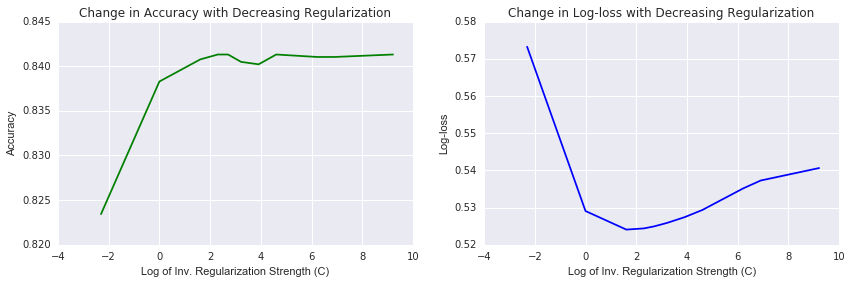

In [211]:
def lr_param_charts():
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.plot(np.log(c_values), accuracies, 'g')
    plt.title("Change in Accuracy with Decreasing Regularization")
    plt.xlabel("Log of Inv. Regularization Strength (C)")
    plt.ylabel("Accuracy")
    plt.subplot(1,2,2)
    plt.plot(np.log(c_values), log_losses, 'b')
    plt.title("Change in Log-loss with Decreasing Regularization")
    plt.xlabel("Log of Inv. Regularization Strength (C)")
    plt.ylabel("Log-loss")

lr_param_charts()

#### Train final model

In [212]:
params = {'C':10.0,'max_iter':1000,'tol':1e-8,'solver':'lbfgs'}
models = train_models(params)

#### Test prediction accuracy

In [213]:
predictions = make_predictions(models)
pred_category = np.argmax(predictions, axis=1)
true_category = np.argmax(Y_test, axis=1)

In [214]:
print 'Accuracy: {}'.format(accuracy_score(true_category, pred_category ))
print 'Log-loss: {}'.format(log_loss(Y_test, predictions))

Accuracy: 0.841309130913
Log-loss: 0.524565689825


#### Analyze errors

In [215]:
analyze_errors(pred_category, true_category)

,Error Rate,Total Session Counts
labels,,
Upstairs,0.536866,434.0
Downstairs,0.479730,296.0
Sitting,0.113990,193.0
Standing,0.090909,154.0
Walking,0.088050,1431.0
Jogging,0.035461,1128.0


### MLP Neural Network Model

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

#### Compile model

In [33]:
model = Sequential()

indim = X.shape[1]
model.add(Dense(512*4, input_dim=indim, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*12, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512*4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

#### Execute model

In [34]:
model.fit(X_train, Y_train,
          nb_epoch=20,
          batch_size=20)

Epoch 1/20
1495/1495 [==============================] - 15s - loss: 1.3570 - acc: 0.5692    
Epoch 2/20
1495/1495 [==============================] - 16s - loss: 0.9978 - acc: 0.6836    
Epoch 3/20
1495/1495 [==============================] - 16s - loss: 0.8675 - acc: 0.7151    
Epoch 4/20
1495/1495 [==============================] - 15s - loss: 0.7939 - acc: 0.7284    
Epoch 5/20
1495/1495 [==============================] - 15s - loss: 0.7430 - acc: 0.7452    
Epoch 6/20
1495/1495 [==============================] - 16s - loss: 0.7133 - acc: 0.7559    
Epoch 7/20
1495/1495 [==============================] - 15s - loss: 0.6769 - acc: 0.7592    
Epoch 8/20
1495/1495 [==============================] - 16s - loss: 0.6613 - acc: 0.7686    
Epoch 9/20
1495/1495 [==============================] - 16s - loss: 0.6308 - acc: 0.7786    
Epoch 10/20
1495/1495 [==============================] - 16s - loss: 0.6075 - acc: 0.7953    
Epoch 11/20
1495/1495 [==============================] - 16s - loss: 

In [35]:
predictions = model.predict(X_test)
print 'Accuracy: {}'.format(accuracy_score(np.argmax(Y_test, axis=1), np.argmax(predictions,axis=1)) )
print 'Log-loss: {}'.format(log_loss(Y_test, predictions))

Accuracy: 0.84803256445
Log-loss: 0.534963186299


### RNN

In [8]:
from keras.layers.core import Flatten
from keras.layers.recurrent import GRU

Using Theano backend.


In [18]:
nnum = (actitracker.shape[0]//500)
lim = nnum * 500
X = actitracker.iloc[:lim,:][['x-accel','y-accel','z-accel']].as_matrix()
Y = actitracker.iloc[:lim,:].groupby(['session'])['activity'].apply(lambda x: max(x))
Y = ohe.fit_transform(le.fit_transform(Y.iloc[:lim]).reshape(-1,1))
X = X[:lim].T.reshape((nnum, 500, 3))

In [ ]:
model = Sequential()
model.add(GRU(32, return_sequences=True, input_dim=3, input_length=500, dropout_W=.5, dropout_U=.5))
model.add(GRU(32, return_sequences=True, dropout_W=.5, dropout_U=.5))
model.add(GRU(32, dropout_W=.5, dropout_U=.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(6))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
indices = np.random.permutation(nnum)
train, test = indices[:(nnum//3)*2], indices[(nnum//3)*2:]

In [ ]:
model.fit(X[train], Y[train],
          nb_epoch=20,
          batch_size=20)

In [ ]:
training_scores = model.evaluate(training_data, training_result)
test_scores = model.evaluate(test_data, test_result)
print("training: %s: %.2f%%" % (model.metrics_names[1], training_scores[1]*100))
print("test: %s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))